In [1]:
from torchvision import datasets, transforms
import torch

dataset_train_t = datasets.CIFAR10('.', train = True, download = True, transform = transforms.ToTensor())
dataset_val_t = datasets.CIFAR10('.', train = False, download = True, transform = transforms.ToTensor())

imgs = torch.stack([img_t for img_t,_ in dataset_train_t], dim=3)
means = imgs.view(3,-1).mean(dim=1)
stds = imgs.view(3,-1).std(dim=1)
dataset_train_transformed = datasets.CIFAR10('.', train = True, download = True,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(means.numpy(), stds.numpy())
                                            ]))
dataset_val_transformed = datasets.CIFAR10('.', train = False, download = True,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize(means.numpy(), stds.numpy())
                                            ]))

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
dataset_train = [(img, label_map[label]) for (img, label) in dataset_train_transformed if label in [0,2]]
dataset_val = [(img, label_map[label]) for (img, label) in dataset_val_transformed if label in [0,2]]
print(len(dataset_train), len(dataset_val))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10000 2000


In [2]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
print(conv.weight.shape) # the shape of batch of kernels in conv
print(conv.bias.shape) # the shape of biases in conv

conv1 = nn.Conv2d(3, 16, kernel_size=5)
print(conv1.weight.shape) # the shape of batch of kernels in conv
print(conv1.bias.shape) # the shape of biases in conv

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 3, 5, 5])
torch.Size([16])


In [3]:
img, lbl = dataset_train[0]
out = conv(img.unsqueeze(0))
out.shape

torch.Size([1, 16, 30, 30])

In [4]:
img, lbl = dataset_train[0]
out = conv1(img.unsqueeze(0))
out.shape

torch.Size([1, 16, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


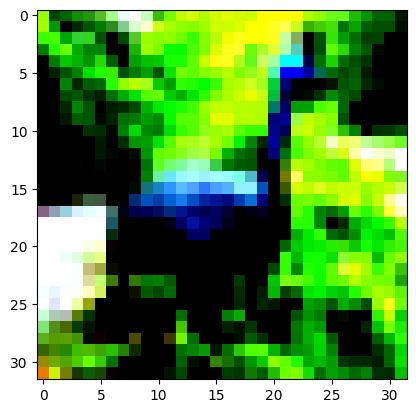

In [5]:
from matplotlib import pyplot as plt

plt.imshow(img.permute(1,2,0))

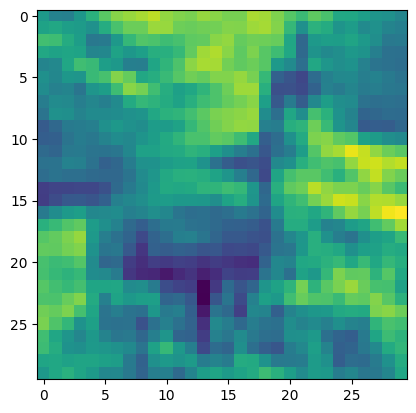

In [6]:
out = conv(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

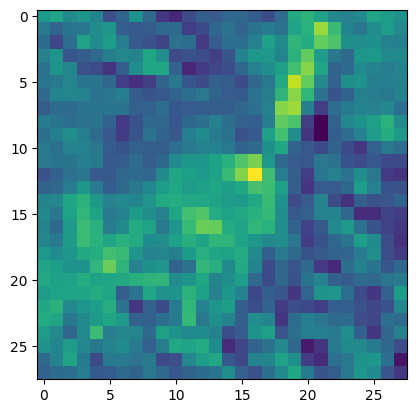

In [7]:
out = conv1(img.unsqueeze(0))
plt.imshow(out[0,15].detach())

In [8]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
print(conv.weight.shape) # the shape of batch of kernels in conv
print(conv.bias.shape) # the shape of biases in conv

conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
print(conv1.weight.shape) # the shape of batch of kernels in conv
print(conv1.bias.shape) # the shape of biases in conv

torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 3, 5, 5])
torch.Size([16])


In [9]:
out = conv(img.unsqueeze(0))
out.shape
#plt.imshow(out[0,15].detach())

torch.Size([1, 16, 32, 32])

In [10]:
out = conv1(img.unsqueeze(0))
out.shape

torch.Size([1, 16, 32, 32])

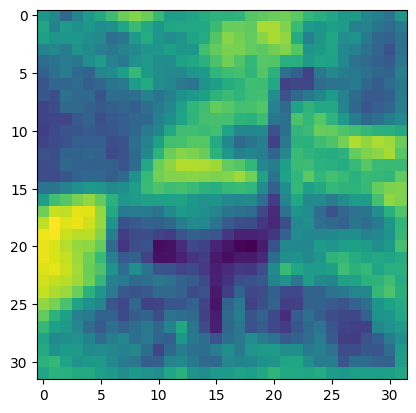

In [11]:
out = conv(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

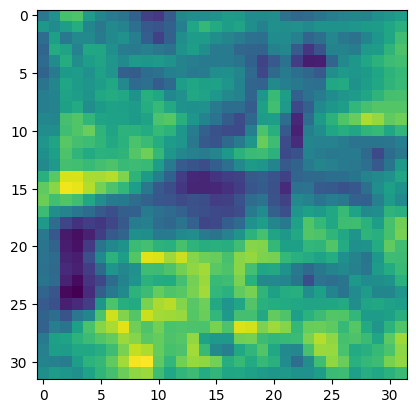

In [12]:
out = conv1(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

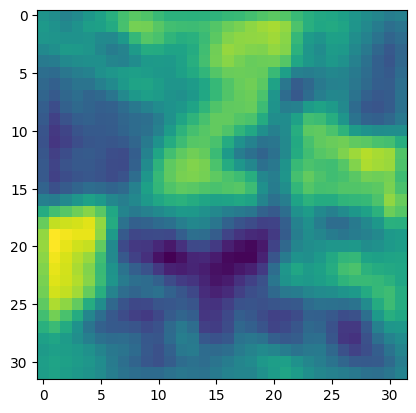

In [13]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0/9.0) #average in each channel and then add together within a neighborhood of 3 *3

out = conv(img.unsqueeze(0))
plt.imshow(out[0,1].detach())

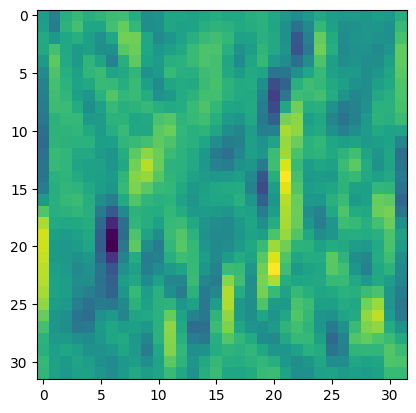

In [14]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0]]) #identify vertical edges

out = conv(img.unsqueeze(0))
plt.imshow(out[0,1].detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


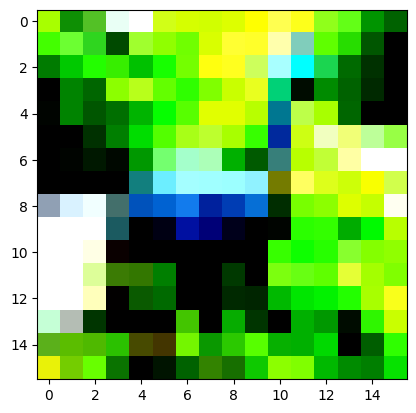

In [15]:
pool = nn.MaxPool2d(2)
out = pool(img)
plt.imshow(out.permute(1,2,0))

In [16]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1), # output: 1 * 16 * 32 * 32
                                                                  # kernel: 3 * 3 * 3
                                                                  # batch of kernels: 16 * 3 * 3 * 3 (weight tensor)
                                                                  # biases: 1 bias per kernel, in total 16
                      nn.Tanh(),
                      nn.MaxPool2d(2), # input: 1 * 16 * 32 * 32, output: 1 * 16 * 16 * 16
                      
                      nn.Conv2d(16, 8, kernel_size=3, padding=1), # output: 1 * 8 * 16 * 16
                                                                  # kernel: 16 * 3 * 3
                                                                  # batch of kernels: 8 * 16 * 3 * 3 (weight)
                                                                  # biases: 1 bias per kernel, in total 8
                      nn.Tanh(),
                      nn.MaxPool2d(2), #input: 1 * 8 * 16 * 16, output: 1 * 8 * 8 * 8
                      nn.Flatten(),
                      nn.Linear(512, 32), # output: 32
                                          # 32 neurons, each having 512 weights, and 1 bias
                                          # weights: 32 * 512, bias: 32
                      nn.Tanh(),
                      nn.Linear(32,2), # output: 2
                                       # 2 neurons, each having 32 weights, and 1 bias
                                       # weights: 2 * 32, bias: 2
                      nn.Softmax(dim=1))

In [17]:
model(img.unsqueeze(0))

tensor([[0.4503, 0.5497]], grad_fn=<SoftmaxBackward0>)

In [18]:
[param.shape for param in model.parameters()]

[torch.Size([16, 3, 3, 3]),
 torch.Size([16]),
 torch.Size([8, 16, 3, 3]),
 torch.Size([8]),
 torch.Size([32, 512]),
 torch.Size([32]),
 torch.Size([2, 32]),
 torch.Size([2])]

In [19]:
[param.numel() for param in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [20]:
sum([param.numel() for param in model.parameters()])

18090

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)
        self.sftmx = nn.Softmax(dim=1)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 512)
        out = self.sftmx(self.fc2(self.act3(self.fc1(out))))
        return out

In [22]:
model = Net()

In [23]:
[param.numel() for param in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [24]:
model(img.unsqueeze(0))

tensor([[0.4734, 0.5266]], grad_fn=<SoftmaxBackward0>)

In [49]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16,8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 512)
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

In [50]:
model = Net()

In [51]:
sum([param.numel() for param in model.parameters()])

18090

In [28]:
model(img.unsqueeze(0))

tensor([[-0.1857, -0.0633]], grad_fn=<AddmmBackward0>)

In [29]:
def training_loop(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1, 1 + n_epochs):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            outs = model(imgs)
            loss = loss_fn(outs, lbls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss
        if epoch % 10 == 0 or epoch <= 3:
            print('epoch %d, loss %f' %(epoch, train_loss/len(train_loader))) # avergae loss over all batches
            

In [30]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=False)


In [31]:
training_loop(n_epochs=100,
              model=model,
              loss_fn=nn.CrossEntropyLoss(),
              optimizer=optim.SGD(model.parameters(), lr = 0.01),
              train_loader=train_loader)

epoch 1, loss 0.577629
epoch 2, loss 0.495306
epoch 3, loss 0.472057
epoch 10, loss 0.343886
epoch 20, loss 0.298745
epoch 30, loss 0.276034
epoch 40, loss 0.253753
epoch 50, loss 0.234914
epoch 60, loss 0.219273
epoch 70, loss 0.202135
epoch 80, loss 0.188669
epoch 90, loss 0.173313
epoch 100, loss 0.158853


In [32]:
def validate(model, loader):
    total = 0
    correct = 0
    for (imgs, lbls) in loader:
        outs = model(imgs)
        max_vals, max_indexes = outs.max(dim=1)
        correct += ((max_indexes == lbls).sum())
        total += imgs.shape[0]
    print('accuracy %f' %(correct/total))

In [33]:
validate(model, val_loader)

accuracy 0.903500


In [34]:
torch.save(model.state_dict(), './model.t')

In [35]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('./model.t'))

<All keys matched successfully>

In [36]:
validate(loaded_model, val_loader)

accuracy 0.903500


In [37]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dev

device(type='cpu')

In [38]:
def training_loop(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1, 1 + n_epochs):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            imgs = imgs.to(device=dev)
            lbls = lbls.to(device=dev)
            outs = model(imgs)
            loss = loss_fn(outs, lbls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss
        if epoch % 10 == 0 or epoch <= 3:
            print('epoch %d, loss %f' %(epoch, train_loss/len(train_loader))) # avergae loss over all batches

model = Net().to(device = dev)

In [39]:
training_loop(n_epochs=100,
              model=model,
              loss_fn=nn.CrossEntropyLoss(),
              optimizer=optim.SGD(model.parameters(), lr = 0.01),
              train_loader=train_loader)

epoch 1, loss 0.567596
epoch 2, loss 0.500357
epoch 3, loss 0.480115
epoch 10, loss 0.345631
epoch 20, loss 0.298922
epoch 30, loss 0.271859
epoch 40, loss 0.251776
epoch 50, loss 0.234878
epoch 60, loss 0.220680
epoch 70, loss 0.201963
epoch 80, loss 0.190840
epoch 90, loss 0.175624
epoch 100, loss 0.165041


In [72]:
class NetWidth(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1) #output: n_chann * 32 * 32
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1)#output: (n_chann//2) * 16 * 16
        self.fc1 = nn.Linear((self.n_chann//2)*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, (self.n_chann//2)*8*8)
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

In [73]:
model = NetWidth(128)

In [75]:
[param.shape for param in model.parameters()]

[torch.Size([128, 3, 3, 3]),
 torch.Size([128]),
 torch.Size([64, 128, 3, 3]),
 torch.Size([64]),
 torch.Size([32, 4096]),
 torch.Size([32]),
 torch.Size([2, 32]),
 torch.Size([2])]

In [76]:
sum([param.numel() for param in model.parameters()])

208546

In [77]:
def training_loop_l2(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1, 1 + n_epochs):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            imgs = imgs.to(device=dev)
            lbls = lbls.to(device=dev)
            outs = model(imgs)
            loss = loss_fn(outs, lbls)
            
            l2_lam = 0.0001 #weight decay
            loss += l2_lam * sum(p.pow(2.0).sum() for p in model.parameters()) #penalty on loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss
        if epoch % 10 == 0 or epoch <= 3:
            print('epoch %d, loss %f' %(epoch, train_loss/len(train_loader)))

In [78]:
model = NetWidth().to(device=dev)

In [79]:
training_loop_l2(n_epochs=100,
                 model=model,
                 loss_fn=nn.CrossEntropyLoss(),
                 optimizer=optim.SGD(model.parameters(), lr = 0.01),
                 train_loader=train_loader)

epoch 1, loss 0.563600
epoch 2, loss 0.474928
epoch 3, loss 0.439893
epoch 10, loss 0.321864
epoch 20, loss 0.276151
epoch 30, loss 0.241550
epoch 40, loss 0.212685
epoch 50, loss 0.189223
epoch 60, loss 0.169118
epoch 70, loss 0.150076
epoch 80, loss 0.130667
epoch 90, loss 0.112869
epoch 100, loss 0.095801


In [81]:
validate(model, train_loader)

accuracy 0.968100


In [83]:
model = NetWidth().to(device=dev)
training_loop(n_epochs=100,
              model=model,
              loss_fn=nn.CrossEntropyLoss(),
              optimizer=optim.SGD(model.parameters(), lr = 0.01, weight_decay=0.0002),
              train_loader=train_loader)

epoch 1, loss 0.533656
epoch 2, loss 0.458477
epoch 3, loss 0.417376
epoch 10, loss 0.311103
epoch 20, loss 0.272928
epoch 30, loss 0.237183
epoch 40, loss 0.209742
epoch 50, loss 0.186304
epoch 60, loss 0.168094
epoch 70, loss 0.150400
epoch 80, loss 0.130393
epoch 90, loss 0.113006
epoch 100, loss 0.097606


In [85]:
validate(model, train_loader)

accuracy 0.967200


In [86]:
class NetDropout(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1) #output: n_chann * 32 * 32
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1)#output: (n_chann//2) * 16 * 16
        self.conv2_dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear((self.n_chann//2)*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, (self.n_chann//2)*8*8)
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

In [88]:
model = NetDropout().to(device=dev)
training_loop(n_epochs=100,
              model=model,
              loss_fn=nn.CrossEntropyLoss(),
              optimizer=optim.SGD(model.parameters(), lr=0.01),
              train_loader=train_loader)

epoch 1, loss 0.560820
epoch 2, loss 0.477326
epoch 3, loss 0.439864
epoch 10, loss 0.359439
epoch 20, loss 0.336107
epoch 30, loss 0.317437
epoch 40, loss 0.300076
epoch 50, loss 0.284860
epoch 60, loss 0.272419
epoch 70, loss 0.260572
epoch 80, loss 0.251416
epoch 90, loss 0.239995
epoch 100, loss 0.227393


In [91]:
validate(model, train_loader)

accuracy 0.902100


In [92]:
class NetDepth(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1) #output: n_chann * 32 * 32
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1) #output: (n_chann//2) * 16 * 16
        self.conv3 = nn.Conv2d(self.n_chann//2, self.n_chann//2, kernel_size=3, padding =1) #output: n_chann//2 * 8 * 8
        self.fc1 = nn.Linear((self.n_chann//2)*4*4, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, (self.n_chann//2)*4*4)
        out = self.fc2(torch.relu(self.fc1(out)))
        return out

In [93]:
model = NetDepth().to(device=dev)

training_loop(n_epochs=100,
              model=model,
              loss_fn=nn.CrossEntropyLoss(),
              optimizer=optim.SGD(model.parameters(), lr=0.01),
              train_loader=train_loader)

epoch 1, loss 0.686325
epoch 2, loss 0.637414
epoch 3, loss 0.572747
epoch 10, loss 0.357938
epoch 20, loss 0.309925
epoch 30, loss 0.274882
epoch 40, loss 0.246157
epoch 50, loss 0.216734
epoch 60, loss 0.197817
epoch 70, loss 0.171282
epoch 80, loss 0.151565
epoch 90, loss 0.124625
epoch 100, loss 0.104012


In [97]:
validate(model, val_loader), validate(model, train_loader)

accuracy 0.897000
accuracy 0.965900


(None, None)

In [98]:
class NetRes(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1) #output: n_chann * 32 * 32
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1) #output: (n_chann//2) * 16 * 16
        self.conv3 = nn.Conv2d(self.n_chann//2, self.n_chann//2, kernel_size=3, padding =1) #output: n_chann//2 * 8 * 8
        self.fc1 = nn.Linear((self.n_chann//2)*4*4, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) #skip node
        out = out.view(-1, (self.n_chann//2)*4*4)
        out = self.fc2(torch.relu(self.fc1(out)))
        return out

In [99]:
model = NetRes().to(device=dev)

training_loop(n_epochs=100,
              model=model,
              loss_fn=nn.CrossEntropyLoss(),
              optimizer=optim.SGD(model.parameters(), lr=0.01),
              train_loader=train_loader)

epoch 1, loss 0.621340
epoch 2, loss 0.499294
epoch 3, loss 0.442966
epoch 10, loss 0.327861
epoch 20, loss 0.283297
epoch 30, loss 0.244325
epoch 40, loss 0.214624
epoch 50, loss 0.189789
epoch 60, loss 0.169038
epoch 70, loss 0.143749
epoch 80, loss 0.117841
epoch 90, loss 0.104821
epoch 100, loss 0.074394


In [100]:
validate(model, val_loader), validate(model, train_loader)

accuracy 0.892500
accuracy 0.974700


(None, None)